## 1 Etude du problème d’optimisation



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#définition des constantes du problème
ccr=1
Tm=18  #températures exprimées en Kelvin
TM=30 
Tin=Tm
h=0.05
k=0.01
b=1/500
N=48
PM=5000
dt=0.5
t_0=23
C=[]


# Fonction température extérieure

def outside_temp(t):
    '''fonction renvoyant la température extérieur à une heure donnée'''
    return 4+8*np.exp((-(t-(24-t_0%24)-12)**2 )/40)   #décalage temporel pour prendre en compte que la date initiale t_0

Te=outside_temp(np.array([i/2 for i in range (48)]))


# Contraintes
def contraintes_ineq(X):
    T = X[:N]
    P = X[N:]
    contraintes = []
    for i in range(N):
        if 7+(24-t_0) <= i/2 % 24 < 9+(24-t_0) or 18+(24-t_0) <= i/2 % 24 < 23+(24-t_0):
            # Contraintes de température pendant les heures d'occupation
            contraintes.append(T[i]-Tm)
            contraintes.append(TM-T[i] )
            
        # Contraintes de puissance de chauffage
        contraintes.append(P[i])
        contraintes.append(PM-P[i])

    return np.array(contraintes)



def contraintes_eq(X):
    T = X[:N]
    P = X[N:]
    contraintes = [T[0]-Tin, P[N-1]]
    for i in range(N-1):
        contraintes.append(np.exp(-(k+h)*dt)*T[i]+((1-np.exp(-(k+h)*dt))/(k+h))*(b*P[i]+h*Te[i])-T[i+1])
    return np.array(contraintes)

# Fonction objectif à minimiser
def cost(X):
    Power = X[N:]
    return dt*np.sum(np.array(Power)*C)*1e-3



def resolution (cpl=1.50):
    global C
    C=[]

    for i in range (48):
        t=i*dt
        if (0+(24-t_0)<=t and t<6+(24-t_0)) or (12+(24-t_0)<=t and t<14+(24-t_0)):
            C.append(ccr)
        else:
            C.append(cpl)
    C=np.array(C)

    # Initialisation des variables
    X0 = np.zeros(2 * N)
    X0[:N] = (TM+Tm)/2  # Température initiale

    # Définition des contraintes et de la fonction objectif pour minimize
    contraintes_dict = ({'type': 'eq', 'fun': contraintes_eq},{'type': 'ineq', 'fun': contraintes_ineq})

    # Résolution avec minimize
    resultat_minimize = minimize(cost, X0, constraints=contraintes_dict, options={'disp': False})

    # Récupération des résultats
    T_resultat = resultat_minimize.x[:N]
    Pow_resultat = resultat_minimize.x[N:]


    T_resultat_temp=[]#liste des résultats réordonnés pour tenir compte de t_0
    Pow_resultat_temp=[]
    
    for i in range ((24-t_0)*2,N):
        T_resultat_temp.append(T_resultat[i])
        Pow_resultat_temp.append(Pow_resultat[i])

    for i in range (0,(24-t_0)*2):
        T_resultat_temp.append(T_resultat[i])
        Pow_resultat_temp.append(Pow_resultat[i])

    T_resultat_temp=np.array(T_resultat_temp)
    Pow_resultat_temp=np.array(Pow_resultat_temp)

    # Affichage des résultats
    temps = np.arange(0, N/2, 0.5)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title('Résolution dans le cas C_pl={}€'.format(cpl))
    plt.plot(temps, T_resultat_temp, label='Température')

    
    plt.fill_between([7,9], Tm, TM, alpha=0.3, color='blue', label='Plages d\'occupation')
    plt.fill_between([18,23], Tm, TM, alpha=0.3, color='blue')
    plt.axhline(y=Tm, color='r', linestyle='--', label='Température min')
    plt.axhline(y=TM, color='g', linestyle='--', label='Température max')
    plt.xlabel('Temps (h)')
    plt.ylabel('Température (°C)')
    plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.plot(temps, Pow_resultat_temp / PM)
    plt.xlabel('Temps (h)')
    plt.ylabel('Puissance de chauffage (normalisée)')
    plt.fill_between([6,12], 0, 1, alpha=0.3, color='orange', label='Heures pleines')
    plt.fill_between([14,23.99], 0, 1, alpha=0.3, color='orange')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    print('La facture à payer est: ', round(cost(resultat_minimize.x), 3),' €.')
    return

resolution()

**1.** 

Sur un intervalle de temps $[t_i;t_{i+1}]$ le tarif d'électricité est supposé constant de valeur $c_i$. Ainsi l'énergie consommée sur cet intervalle de temps étant $(t_{i+1} - t_i)P_i = \Delta t P_i$, le prix a payer est alors $c_i \Delta t P_i$.

Au final, la fatcure totale est obtenue en sommant les factures sur les intervalles $[t_i;t_{i+1}]$ pour $i \in [0,n]$, donc **le prix total à payer est**: 

$$\sum_{i=0}^{n}{c_i \Delta t P_i}=\Delta t  \sum_{i=0}^{n}{c_i P_i}$$

**2.**

**Interpréter l’équation (2). Quels échanges thermiques incorpore-t-elle ? Cette modélisation vous semblet-elle raisonnable ?**

**3. Version 1**

L'objectif du problème est de **minimiser la facture** *(5)* de chaufage à payer en **respectant différentes contraintes**.

On considère que les variables $(T_i^e)_{i \in [1,N]}$ sont entièrement définies par une loi extérieure et ne dépendent pas de l'utilisateur. De plus, on constate que comme $T_{i+1}$ ne dépend que de $T_{i}$ et de $P_{i}$, et que $T_0$ est imposé, $\forall i \in [1,N]$ $T_i$ est entièrement définit par $P_0,...,P_{i-1}$ et $T_{in}$ *(16)*.

On considère ainsi les variables de décisions $$x=(P_0,...,P_i,...P_{N-1})$$ au **nombre de $N$** (on a en effet $P_N=0$ imposé par l'énoncé).

On pose de plus, afin de traduire la recherche de minimisation de la facture *(5)*,
$$f(x)=\Delta t  \sum_{i=0}^{N-1}{c_i P_i}$$
 afin de chercher à résoudre $\min\limits_{x \in\Re ^{N}}{f(x)}$.

On traduit la contrainte de confort *(4)* et de puissance disponible *(1)* en posant: $$c_{in}(x)= \begin{pmatrix} T_m - T_0 \\  T_0 - T_M \\ P_0 - P_M \\ ... \\ T_m - T_i \\  T_i - T_M \\ P_i - P_M \\ ... \\ T_m - T_N \\  T_N - T_M \\ P_N - P_M  \end{pmatrix}  \le 0$$

qui au vu de *(16)* est entièrement déterminé par $x$.

Enfin, on traduit l'évolution (discrétisée) de la température *(2)* et les conditions initiales *(3)*: $$c_{eq}(x)= \begin{pmatrix} e^{-(k+h) \Delta t} T_0 + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_0 +hT_0^e) - T_{1}  \\ ... \\  e^{-(k+h) \Delta t} T_i + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_i +hT_i^e) - T_{i+1} \\ ... \\ e^{-(k+h) \Delta t} T_{N-1} + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_{N-1} +hT_{N-1}^e) - T_{N} \end{pmatrix}  = 0$$

qui au vu de *(16)* est aussi entièrement déterminé par $x$.

**4.**


D'une part **f est clairement convexe** *(17)*: $\nabla ^2 f(x)=0 \geq 0$.

D'autre part, comme par *(16)* chaque ligne de $c_{eq}$ est combinaison linéaire des $(P_i)_i$ sommé à un terme constant, on peut écrire $c_{eq}(x) = Ax + B$

Ainsi la contrainte égalité **$c_{eq}$ est affine** *(18)*.

Enfin **$c_{in}$ est convexe** *(19)* car $\forall i$ $  c_{in,3i}(x)=T_m - T_i,  c_{in,3i+1}(x)=T_i- T_M ,  c_{in,3i+2}(x)=P_i - T_M$ sont clairement convexes (combinaisons linéaires des $P_i$).

Ainsi, par *(17), (18)* et *(19)*, le **problème étudié est convexe**. Il s'agit par ailleurs d'un **problème d'optimalité à contrainte égalité et inégalité**.

## 2 Etude et résolution numérique du problème individuel


**5.**

Le problème étant convexe, il est possible d'utiliser le **théorème de Karush-Kuhn-Tucker (KKT)** pour trouver des potentielles solutions (les conditions nécessaires aux théorème sont aussi dans ce cas suffisantes).

On pourrait aussi utiliser **l'algorithme d'Uzawa** pour résoudre le problème numériquement.


**AUTRES METHODES ?**


**6.**

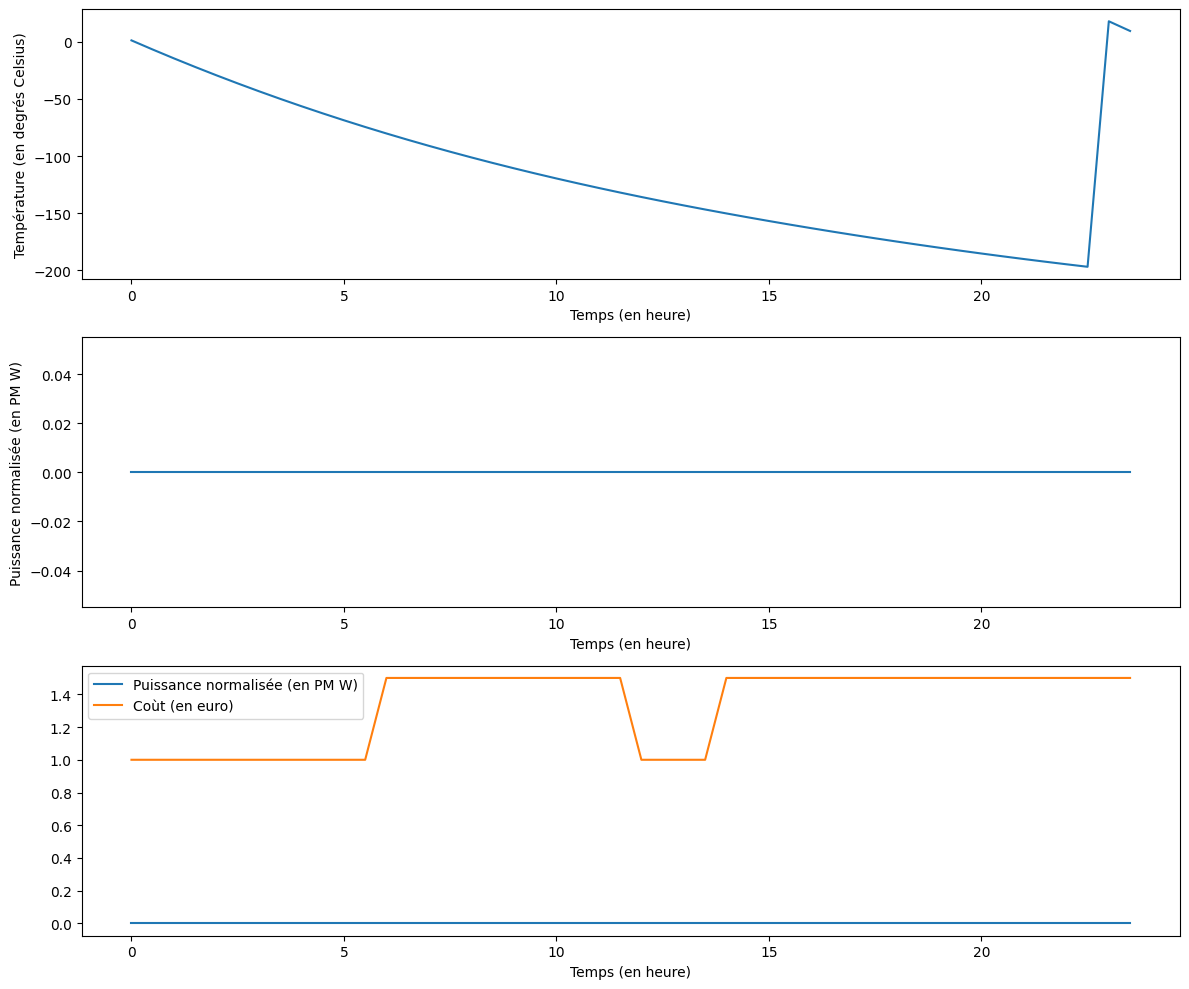

In [24]:
import numpy as np 
import matplotlib.pyplot as plt

#définition des constantes du problème
c_cr=1
c_pl=1.50
T_m=18 + 273 #températures exprimées en Kelvin
T_M=30 + 273
T_in=T_m
h=0.05
k=0.01
b=1/500
P_M=5000
dt=0.5
t_0=23

temps=[i/2 for i in range (0,48)]
temps=np.array(temps)
T=np.zeros(48) #liste des températures (de 00h à 23h30 avec un pas de 30min)
Power=np.zeros(48) #liste des puissances (de 00h à 23h30 avec un pas de 30min)
T[t_0*2]=T_in   #ajout de la condition initiale de température (algo commencant à 23h)


#construction de la liste des tarifs C sous la forme [c_0, c_1, ...] où c_0 correspond donc au tarif de 00h à 00h30, c_1 de 00h30 à 1h00 etc
C=[]
for i in range (48):
    t=i*dt
    if (0<=t and t<6) or (12<=t and t<14):
        C.append(c_cr)
    else:
        C.append(c_pl)
C=np.array(C)

#construction de la liste de présence P sous la forme [True, False, ...], le booléen à l'indice i indiquant si les occupants sont présents sur [t_i,t_i+1] 
P=[]
for i in range (48):
    t=i*dt
    if (7<=t and t<9) or (18<=t and t<23):
        P.append(True)
    else:
        P.append(False)
P=np.array(P)


def outside_temp(ti):
    '''fonction renvoyant la température extérieur à une heure donnée'''
    t=ti%24 #obtenir l'heure modulo 24
    return 4+8*np.exp((-(t-12)**2 )/40)


def evolution_temp(Ti,Pi,Tie):
    '''fonction prenant en paramètre T_i, P_i et T_i_e et renvoyant T_(i+1)'''
    return np.exp(-(k+h)*dt)*Ti+ ((1-np.exp(-(k+h)*dt))/(k+h))*(b*Pi+h*Tie)


##algo de modélisation
for i in range (48):
    indice=t_0*1/dt+i          #indice des listes 
    indice_precedent=t_0*1/dt+i -1
    if indice>=48:
        indice=indice%48
    if indice_precedent>=48:
        indice_precedent=indice_precedent%48

    t=(t_0+i*dt)%24     #heure "actuelle"; on travail sur des heures comprises entre 0h et 24h

    if t==t_0:         #cas de base de la modélisation
        
        #algo de résolution
        pass
    else:
        T[int(indice)]=evolution_temp(T[int(indice_precedent)],P[int(indice_precedent)],outside_temp(t))
        #algo de résolution



##affichage des graphiques intéressants
plt.figure(figsize=(12, 10))       

plt.subplot(3, 1, 1)
plt.plot(temps, T-273)
plt.xlabel('Temps (en heure)')
plt.ylabel('Température (en degrés Celsius)')

plt.subplot(3, 1, 2)
plt.plot(temps, Power/5000)
plt.xlabel('Temps (en heure)')
plt.ylabel('Puissance normalisée (en PM W)')

plt.subplot(3, 1, 3)
plt.plot(temps, Power/5000, label='Puissance normalisée (en PM W)')
plt.plot(temps,C, label='Coùt (en euro)')
plt.xlabel('Temps (en heure)')
plt.legend()

plt.tight_layout()     
plt.show()